# <center>ディープラーニング入門</center>
# <center>セマンティック・セグメンテーションとUNet 2：学習</center>



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
!wget -P './lung_cancer' http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/12/Segmentation01_RGB.zip

--2020-09-28 13:49:14--  http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/12/Segmentation01_RGB.zip
Resolving imgcom.jsrt.or.jp (imgcom.jsrt.or.jp)... 158.199.228.161
Connecting to imgcom.jsrt.or.jp (imgcom.jsrt.or.jp)|158.199.228.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1869946 (1.8M) [application/zip]
Saving to: ‘./lung_cancer/Segmentation01_RGB.zip’

Segmentation01_RGB. 100%[===================>]   1.78M  3.27MB/s    in 0.5s    

2020-09-28 13:49:15 (3.27 MB/s) - ‘./lung_cancer/Segmentation01_RGB.zip’ saved [1869946/1869946]



In [28]:
!pwd

/home/input/100knocks


In [27]:
!ls ./lung_cancer

Segmentation01_RGB  Segmentation01_RGB.zip


In [14]:
# !unzip ./lung_cancer/Segmentation01_RGB.zip

Archive:  ./lung_cancer/Segmentation01_RGB.zip
  inflating: Segmentation01_RGB/list_test.txt  
  inflating: Segmentation01_RGB/list_train.txt  
  inflating: Segmentation01_RGB/test/label/0.png  
  inflating: Segmentation01_RGB/test/label/1.png  
  inflating: Segmentation01_RGB/test/label/2.png  
  inflating: Segmentation01_RGB/test/label/3.png  
  inflating: Segmentation01_RGB/test/label/4.png  
  inflating: Segmentation01_RGB/test/label/5.png  
  inflating: Segmentation01_RGB/test/label/6.png  
  inflating: Segmentation01_RGB/test/label/7.png  
  inflating: Segmentation01_RGB/test/label/8.png  
  inflating: Segmentation01_RGB/test/label/9.png  
  inflating: Segmentation01_RGB/test/org/0.png  
  inflating: Segmentation01_RGB/test/org/1.png  
  inflating: Segmentation01_RGB/test/org/2.png  
  inflating: Segmentation01_RGB/test/org/3.png  
  inflating: Segmentation01_RGB/test/org/4.png  
  inflating: Segmentation01_RGB/test/org/5.png  
  inflating: Segmentation01_RGB/test/org/6.png  
  i

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

今回使うモデルのサイズと深さを決めておきましょう：

In [3]:
SIZE = 128
DEPTH = 4

## 1. UNetの作成

前回のノートブックのコードを少しシンプルにして、DropOutを入れたモデルを作ることにします

In [4]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def conv_block(inputs, kernel_size=(3,3), n_channels=32):
    
    # Convを二回行う
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(n_channels, kernel_size, padding='same')(x)
    x = layers.Activation('relu')(x)

    return x

def upconv_block(inputs, n_channels=32):
    
    # Upsamplingでサイズを倍にした後、2x2 Convでチャネル数を変更。TransposeConvを使うのでも良い
    x = layers.UpSampling2D((2, 2))(inputs)
    x = layers.Conv2D(n_channels, (2,2), padding='same')(x)

    return x

In [5]:
def build_unet(size=(256,256,1), depth=4, n_classes=1):

    channels = [64 * 2**i for i in range(depth+1)]

    x_in = layers.Input(size)
    x = x_in

    downsampling_layers = []

    for i, c in enumerate(channels[:-1]):
        x_unpool = conv_block(inputs=x, n_channels=c)
        if i == (depth-1):
            x_unpool = layers.Dropout(0.5)(x_unpool)
        downsampling_layers.append(x_unpool)
        x = layers.MaxPooling2D((2,2))(x_unpool)

    x = conv_block(inputs=x, n_channels=channels[-1])
    x = layers.Dropout(0.5)(x)

    channels = channels[:-1][::-1]
    downsampling_layers = downsampling_layers[::-1]

    for i, c in enumerate(channels):
        x = upconv_block(inputs=x, n_channels=c)
        x = layers.Concatenate()([x, downsampling_layers[i]])
        x = conv_block(inputs=x, n_channels=c)

    x = layers.Conv2D(n_classes, (1,1), padding='same', activation='sigmoid')(x)

    return Model(inputs=x_in, outputs=x)

この関数でモデルを作ってみましょう：


In [6]:
model = build_unet(size=(SIZE,SIZE,1), depth=DEPTH, n_classes=1)

モデルの形状を可視化して確認しましょう：

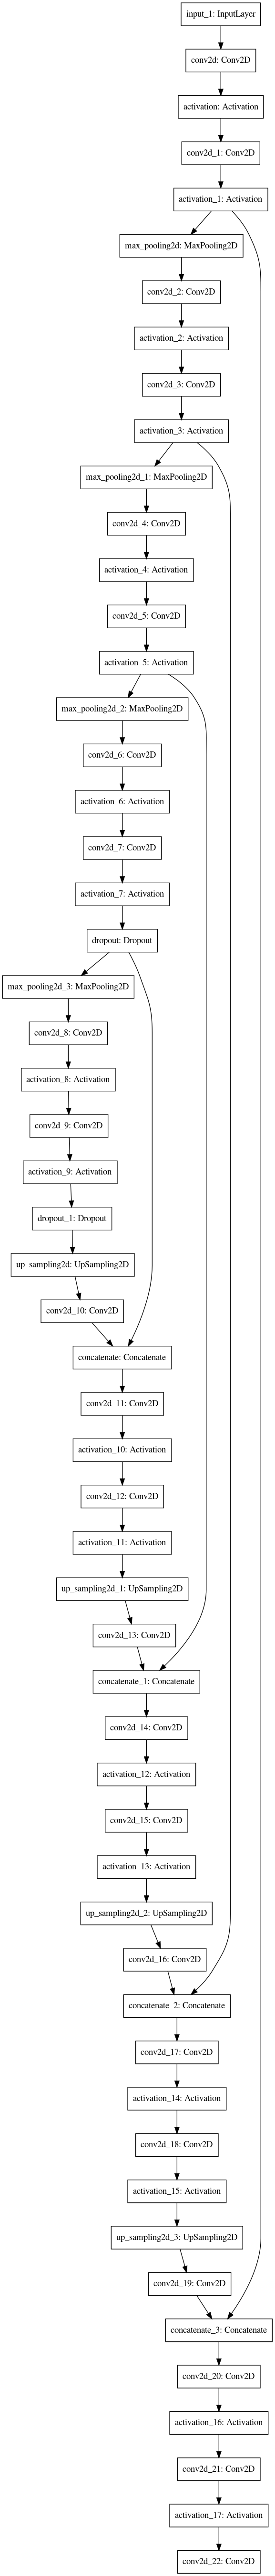

In [7]:
from tensorflow.keras.utils import plot_model
import pydot

plot_model(model)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

## 2. 訓練

前のノートブックで用意したデータを使います。まず画像の前処理関数を作っておき

In [9]:
def preprocessing_function(x):
    return x / 255.

これをデータジェネレータに渡して前処理も組み込みます：

In [32]:
!ls /home/input/100knocks/lung_cancer/Segmentation01_RGB/train/label

1.png	14.png	19.png	23.png	28.png	32.png	37.png	41.png	46.png	50.png
10.png	15.png	2.png	24.png	29.png	33.png	38.png	42.png	47.png	6.png
11.png	16.png	20.png	25.png	3.png	34.png	39.png	43.png	48.png	7.png
12.png	17.png	21.png	26.png	30.png	35.png	4.png	44.png	49.png	8.png
13.png	18.png	22.png	27.png	31.png	36.png	40.png	45.png	5.png	9.png


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 乱数のシード
rand_seed = 42 

image_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 rotation_range = 0.2,
                 shear_range = 0.05,
                 zoom_range = 0.05,
                 preprocessing_function = preprocessing_function
                 )
mask_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 rotation_range = 0.2,
                 shear_range = 0.05,
                 zoom_range = 0.05,
                 preprocessing_function = preprocessing_function
                 )

image_generator =image_datagen.flow_from_directory('/home/input/100knocks/lung_cancer/Segmentation01_RGB/train/org',
                                                   class_mode=None, # 分類じゃないので、カテゴリに関するyを使わない
                                                   seed=rand_seed, 
                                                   target_size=(SIZE, SIZE), 
                                                   color_mode='grayscale') # 白黒なので1-channelにしておく

mask_generator = mask_datagen.flow_from_directory('/home/input/100knocks/lung_cancer/Segmentation01_RGB/train/label',
                                                  class_mode=None, 
                                                  seed=rand_seed, # 上と同じ乱数シードにしておくのがミソ。これで常にX線写真に対応するマスク画像を渡してくれる
                                                  target_size=(SIZE, SIZE), 
                                                  color_mode='grayscale')

train_generator = zip(image_generator, mask_generator) # zipで二つのイテレータをまとめる

Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


ミニバッチサイズ5（steps_per_epoch=50//5）で学習させてみる

In [34]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')

history = model.fit(train_generator, 
          steps_per_epoch=50//5, 
          epochs=64)

Train for 10 steps
Epoch 1/64
 1/10 [==>...........................] - ETA: 22s

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-34-722f5d5db150>:7) ]] [Op:__inference_distributed_function_6547]

Function call stack:
distributed_function


## 3. 学習結果を見てみる

データジェネレータから適当に訓練画像を取ってきて、それに関してセグメンテーションがうまくいっているかを見て見ましょう。まずは訓練ミニバッチを一つとってきます

In [23]:
xs, ys = next(train_generator)

In [24]:
print(xs.shape)
print(ys.shape)

(0, 128, 128, 1)
(0, 128, 128, 1)


それぞれxとyのペアを見てみると

In [25]:
plt.imshow(xs[0,:,:,0], cmap='gray')
plt.show()

plt.imshow(ys[0,:,:,0], cmap='gray')
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

ではこれら訓練ミニバッチのうち16枚で、予測画像（左）と正解画像（右）を比較して見ましょう：

In [ ]:
preds = model.predict(xs)

for i in range(16):
    img = np.concatenate([preds[i,:,:,0], ys[i,:,:,0]], axis=1)
    plt.imshow(img, cmap='gray')
    plt.show()

結構綺麗にいっています。

<b>ここでは検証データは用意してありませんので、検証（テスト）データでうまくいっているかも最後に確認しましょう。</b>